In this Notebook, we aim at creating some DataDriven surrogate models for the 1D Heat Equation in the divergence forme: 

$$
- \nabla \cdot \left(D(x)\, \nabla u\right) = 1
$$

the diffusion coefficient $D$ is no longer considered constant. Our goal here is to create params to solutions models mapping from $D$ to $u_D$.  

As we want to do it in a data driven manner, we first need a solver to generate data. To do so, we use the following finite difference scheme:

$$
- (\Delta x)^{-2}\left[D_{i-\frac12}\, u_{i-1} - (D_{i - \frac12} + D_{i +\frac12})\,u_i + D_{i + \frac12}\,u_{i + 1}\right] = 1
$$

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from scipy import interpolate
import torch
import copy

In [2]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family': 'serif', 'size' : 12})
rc('figure', **{'figsize' : (5, 3)})

In [3]:
sys.path.insert(1, '../..')

In [4]:
np.random.seed(seed=123)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Data Generation

First we need to generate data, to do so, we use the Solver module that will do everything for us in exchange for a dictionnary of params as input. 

There is some already recorded params in the config_step_3.py file 

In [6]:
from solvers.PoissonSolver import PoissonSolver
from config_step_3 import PARAMS_SOLVER

we consider in this work the terms of diffusion as Gaussian functions of center to be chosen in a uniform random matter:

In [7]:
def logn_fct(grid, num_fct, num_sample = 5, mean = 0., sigma = 1.):
    
    assert num_sample < len(grid)
    
    idx = np.arange(0, len(grid), int(len(grid)/num_sample) + 1)
    idx[-1] = len(grid) - 1
    
    x = grid[idx]
    
    U = []
    for _ in range(num_fct):
        
        u = np.random.lognormal(mean, sigma, size = num_sample)
        f = interpolate.interp1d(x, u, kind = 'quadratic')
        min_D = np.abs(np.min(np.minimum(f(grid), 0)))
        new_D = f(grid) + min_D + 1e-1
        U.append(new_D)
    
    return np.stack(U)

In [8]:
x = np.linspace(0., 1., 101)
D = logn_fct(x, 1)[0]
PARAMS_SOLVER['D'] = D

In [9]:
params_solver = copy.deepcopy(PARAMS_SOLVER)
solver = PoissonSolver(params=params_solver)

In [10]:
u = solver.solve

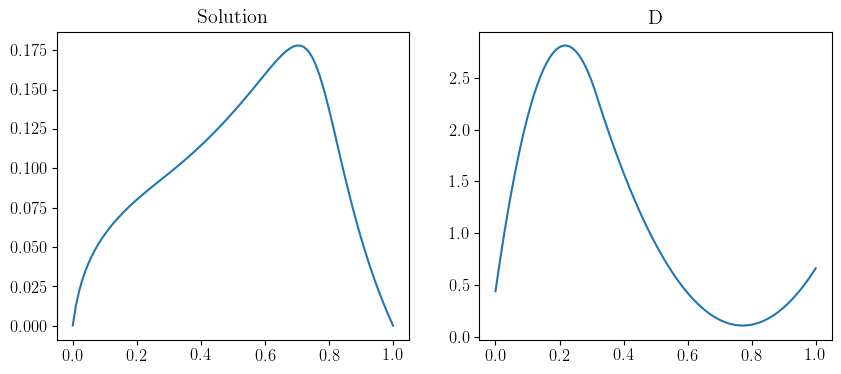

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(solver.x, u)
ax2.plot(solver.x, D)

ax1.set_title('Solution')
ax2.set_title('D')
plt.show()

In [12]:
VD = logn_fct(x, num_fct=1000)

In [13]:
# Vectorized solver
VU = solver.Vsolve(vect = 'D', D = VD)

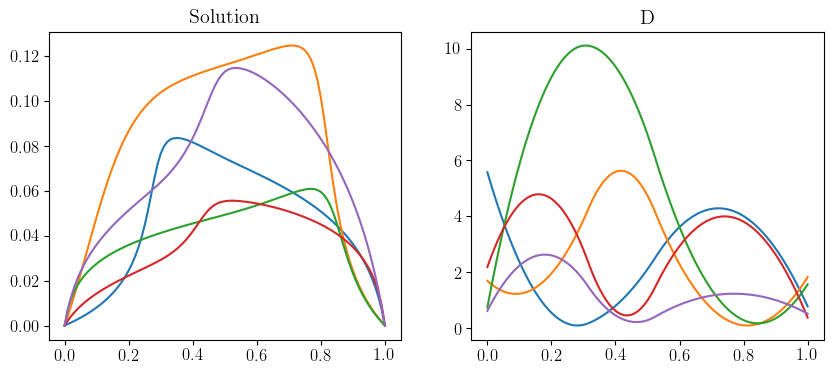

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
for sample in range(0, 5):
    ax1.plot(solver.x, VU[sample])
    ax2.plot(solver.x, VD[sample])
ax1.set_title('Solution')
ax2.set_title('D')
plt.show()

## DataDriven surrogate models creation

Now we want to create multiple surrogate models through different methods: POD, MLP, FNO and DeepONet

In practice, we just need to call DDMethod that will handle everything for us

In [15]:
from methods.DataDrivenMethods import DDMethod

In [16]:
# chose methods that you want to use
method_names = ['POD', 'MLP', 'DEEPONET', 'FNO'] 

Best model parameters and optimization hyperparameters for fitting each method have already been computed using optuna (see https://optuna.readthedocs.io/en/stable/index.html), we just need to import them (see optuna folder for more detail on the training)

In [17]:
from config_step_3_bis import PARAMS_METHODS, HYPERPARAMS_METHODS

In [18]:
PARAMS_METHODS['MLP']

{'method_name': 'MLP',
 'layer_dims': [2, 40, 33, 70, 89, 55, 118, 1],
 'activations': 'tanh',
 'device': device(type='cpu'),
 'seed': 123}

Create DDMethod object for each method

In [19]:
all_methods = {}
for method in method_names:
    params_method = copy.deepcopy(PARAMS_METHODS[method])
    params = {'solver': params_solver, 'method': params_method}
    all_methods[method] = DDMethod(params=params)

In [20]:
d_train, d_val, u_train, u_val = sklearn.model_selection.train_test_split(VD, VU, test_size=0.2, random_state=123)

In [21]:
nx = PARAMS_SOLVER['nx']
D_train = torch.Tensor(d_train).view(-1, 1)
D_val = torch.Tensor(d_val).view(-1, 1)

In [22]:
x = torch.Tensor(solver.x).view(-1, 1)
X_train = x.repeat(d_train.shape[0], 1)
X_val = x.repeat(d_val.shape[0], 1)

In [23]:
DX_train = torch.cat((D_train, X_train), dim=1)
DX_val = torch.cat((D_val, X_val), dim=1)
U_train = torch.Tensor(u_train).view(-1, 1)
U_val = torch.Tensor(u_val).view(-1, 1)

In [24]:
D_fno_train = torch.Tensor(d_train).unsqueeze(-1)
D_fno_val = torch.Tensor(d_val).unsqueeze(-1)

Load models for Neural Networks, and fit for methods

In [25]:
for method in method_names:
    hyperparams_method = copy.deepcopy(HYPERPARAMS_METHODS[method])
    if method == 'POD':
        all_methods[method].fit(hyperparameters=hyperparams_method, U=VU)
    elif method == 'FNO':
        all_methods[method].fit(hyperparameters=hyperparams_method, 
                                D_train=D_fno_train, D_val=D_fno_val, U_train=u_train, U_val=u_val)
        
    elif method == 'DEEPONET':
        all_methods[method].fit(hyperparameters=hyperparams_method, 
                                U_train=u_train, U_val=u_val, D_train=d_train, D_val=d_val)
        
    elif method in ['MLP']:
        all_methods[method].fit(hyperparameters=hyperparams_method, 
                                U_train=U_train, U_val=U_val, DX_train=DX_train, DX_val=DX_val, 
                                data_ratio=1., physics_ratio=0.)
        
    # elif method == 'PINN':
    #     all_methods[method].fit(hyperparameters=hyperparams_method, 
    #                              DX_train=DX_train, DX_val=DX_val, U_val=U_val, 
    #                             data_ratio=0., physics_ratio=1., loss='D', w_r=11)
       
    # elif method == 'MLPINN':
    #     all_methods[method].fit(hyperparameters=hyperparams_method, DX_train=DX_train, DX_val=DX_val, U_train=U_train, U_val=U_val,
    #                        data_ratio=1., physics_ratio=1., loss='D')
        
    # elif method in ['MLP', 'DEEPONET', 'FNO']:
    #     all_methods[method].load_state_dict(f'optuna/step_3_bis/{method}.pt')

Fitting POD
POD fitted
Fitting MLP


[tr : 2.0e-03, val : 1.8e-03]:  29%|█████████████████████████████████████████████▎                                                                                                                 | 2851/10000 [11:15<28:13,  4.22it/s]


KeyboardInterrupt: 

In [ ]:
for method in all_methods:
    if method in ['MLP', 'PINN', 'DEEPONET', 'FNO', 'MLPINN']:
        torch.save({'model_state_dict': all_methods[method].state_dict, 
                    'loss_dict': all_methods[method].loss_dict()}
                   , f'optuna/step_3_bis/{method}.pt')

# Plot performances for each method

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6)) 

for i, (ax, method) in enumerate(zip(axs.flatten(), all_methods)):
    all_methods[method].plot(ax)
    ax.title.set_text(method)
    
fig.tight_layout()
plt.savefig('figs/step_3_bis/fitting_step_3_bis.pdf', bbox_inches='tight')
plt.show()

## In/Out distribution analysis

In [ ]:
new_D = logn_fct(solver.x, 1)[0]
solver.change_D(D=new_D)
U_FD = solver.solve

fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize= (10, 4))
ax_0.plot(solver.x, U_FD, '--', label=f'FD (True)')

for method in all_methods:
    U_pred = all_methods[method].apply_method(phi = new_D, D = new_D).flatten()
    ax_0.plot(solver.x, U_pred, label=f'{method}')
    
# ax_0.title.set_text(f'$a$ = {new_a}')
ax_0.legend()

OOD_D = logn_fct(solver.x, 1)[0]
solver.change_D(D=OOD_D)
U_OOD = solver.solve

ax_1.plot(solver.x, U_OOD, '--', label=f'FD (True)')

for method in all_methods:
    U_pred = all_methods[method].apply_method(phi = OOD_D, D = OOD_D).flatten()
    ax_1.plot(solver.x, U_pred, label=f'{method}')
    
# ax_1.title.set_text(f'$a$ = {OOD_a}')
ax_1.legend()
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

for i, (ax, method) in enumerate(zip(axs.flatten(), all_methods)):
    all_methods[method].parity_plot(U=u_train, phi=d_train, D=d_train, ax=ax, label=f'Train {method}', color='green')
    all_methods[method].parity_plot(U=u_val, phi=d_val, D=d_val, ax=ax, label=f'Validation {method}', color='blue')
    ax.legend()
    ax.set_yscale('log')
    ax.set_xscale('log')
    
plt.tight_layout()
plt.savefig('figs/step_3_bis/train_val_step_3_bis.pdf', bbox_inches='tight')
plt.show()

In [ ]:
#### OUT OF DISTRIBUTION D GENERATION ######
OOD_centers = np.concatenate([np.linspace(0.1, 0.2, 21), np.linspace(0.8, 0.9, 21)])
OOD_VD = logn_fct(solver.x, 1, centers=OOD_centers)
OOD_VU = solver.Vsolve(vect = 'D', D = OOD_VD)
                
OOD_VD = torch.Tensor(OOD_VD)
OOD_VU = torch.Tensor(OOD_VU)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

for i, (ax, method) in enumerate(zip(axs.flatten(), all_methods)):
    all_methods[method].parity_plot(U=VU, phi = VD, D=VD, ax=ax, label=f'ID {method}', color='green')
    all_methods[method].parity_plot(U=OOD_VU, phi= OOD_VD, D=OOD_VD, ax=ax, label=f'OOD {method}', color='blue')
    ax.legend()
    ax.set_yscale('log')
    ax.set_xscale('log')
    
plt.tight_layout()
# plt.savefig('figs/step_3_bis/ID_OOD_step_3_bis.pdf', bbox_inches='tight')
plt.show()